In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
data_dir = Path(r'./drive/MyDrive/Fish_Dataset')

In [ ]:
# Bộ lọc để xóa những hình ảnh 'GT'
filter_GT = lambda x : True if os.path.split(os.path.split(x)[0])[1][-2:] != 'GT' else False
map_label = lambda x : os.path.split(os.path.split(x)[0])[1]

In [ ]:
filter_GT

<function __main__.<lambda>>

In [ ]:
# danh sách hình ảnh và nhãn
img_dir = list(filter(filter_GT, data_dir.glob(r'**/*.png')))
label = list(map(map_label, img_dir))

In [ ]:
data = pd.DataFrame({'img_dir':img_dir, 'label':label}).astype('str')


In [ ]:
types = data['label'].unique()
n_types = len(types)

print(types)
print(n_types)

['Striped Red Mullet' 'Black Sea Sprat' 'Hourse Mackerel' 'Sea Bass'
 'Shrimp' 'Trout' 'Red Mullet' 'Red Sea Bream' 'Gilt-Head Bream']
9


In [ ]:
data.shape

(9000, 2)

In [ ]:
for Type in types:
    n = data.loc[data['label']==Type, 'label'].count()
    print(f'{n} ===> {Type}')

1000 ===> Striped Red Mullet
1000 ===> Black Sea Sprat
1000 ===> Hourse Mackerel
1000 ===> Sea Bass
1000 ===> Shrimp
1000 ===> Trout
1000 ===> Red Mullet
1000 ===> Red Sea Bream
1000 ===> Gilt-Head Bream


In [ ]:
# image_sizes = data['img_dir'].apply(lambda x : plt.imread(x).shape)
# print(image_sizes.value_counts())

In [ ]:
data = data.sample(frac=1).reset_index(drop = True)
data.head(9)

,img_dir,label
0,drive/MyDrive/Fish_Dataset/Trout/Trout/00348.png,Trout
1,drive/MyDrive/Fish_Dataset/Shrimp/Shrimp/00095...,Shrimp
2,drive/MyDrive/Fish_Dataset/Striped Red Mullet/...,Striped Red Mullet
3,drive/MyDrive/Fish_Dataset/Gilt-Head Bream/Gil...,Gilt-Head Bream
4,drive/MyDrive/Fish_Dataset/Shrimp/Shrimp/00710...,Shrimp
5,drive/MyDrive/Fish_Dataset/Red Sea Bream/Red S...,Red Sea Bream
6,drive/MyDrive/Fish_Dataset/Shrimp/Shrimp/00203...,Shrimp
7,drive/MyDrive/Fish_Dataset/Trout/Trout/00459.png,Trout
8,drive/MyDrive/Fish_Dataset/Sea Bass/Sea Bass/0...,Sea Bass


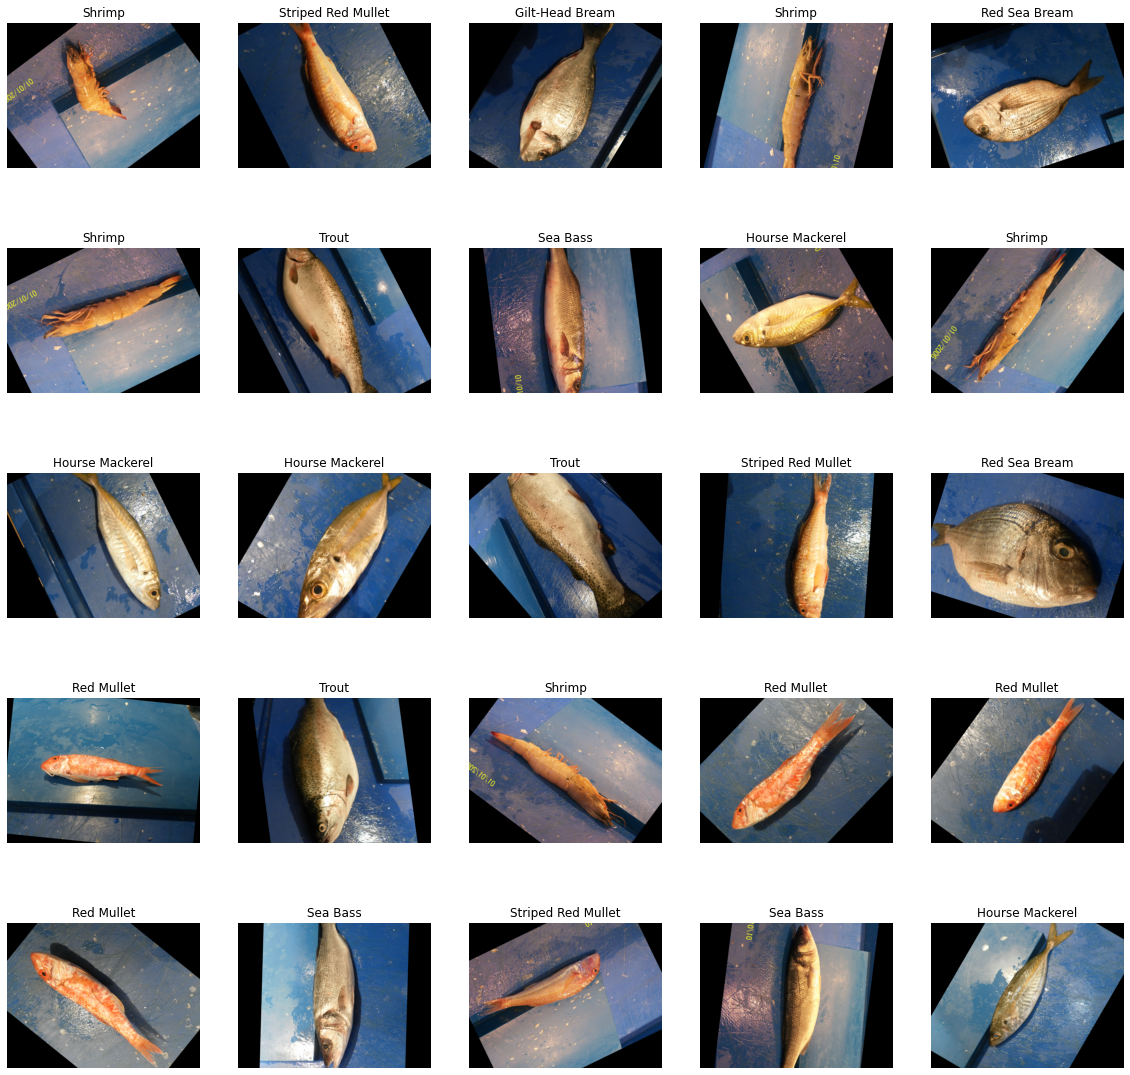

In [ ]:
plt.figure(figsize=(20, 20))
n_img = (5, 5)
for i in range(1, (n_img[0] * n_img[1]) +1):
    plt.subplot(n_img[0], n_img[1], i)
    plt.axis('off')
    plt.title(data['label'][i])
    plt.imshow(plt.imread(data['img_dir'][i]))

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, train_size=0.9, random_state=1)

In [ ]:
training_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input,
    validation_split=0.2
)

testing_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.resnet50.preprocess_input
)

In [ ]:
train_images = training_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_dir',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=45,
    subset='training'
)

val_images = training_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_dir',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=45,
    subset='validation'
)

test_images = testing_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_dir',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
)

Found 6480 validated image filenames belonging to 9 classes.
Found 1620 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

Dense1 = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
Dense2 = tf.keras.layers.Dense(128, activation='relu')(Dense1)
outputs = tf.keras.layers.Dense(n_types, activation='softmax')(Dense2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
ep = 20
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

history = model.fit( train_images,validation_data=val_images,epochs=ep,callbacks= EarlyStopping)

Epoch 1/20
203/203 [==============================] - 2207s 11s/step - loss: 0.1603 - accuracy: 0.9522 - val_loss: 0.0141 - val_accuracy: 0.9963
Epoch 2/20
203/203 [==============================] - 104s 515ms/step - loss: 0.0322 - accuracy: 0.9901 - val_loss: 0.0093 - val_accuracy: 0.9969
Epoch 3/20
203/203 [==============================] - 100s 494ms/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.0029 - val_accuracy: 0.9994
Epoch 4/20
203/203 [==============================] - 98s 482ms/step - loss: 6.0776e-04 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 0.9994
Epoch 5/20
203/203 [==============================] - 98s 483ms/step - loss: 3.0479e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9988
Epoch 6/20
203/203 [==============================] - 99s 488ms/step - loss: 2.2083e-04 - accuracy: 1.0000 - val_loss: 0.0019 - val_accuracy: 0.9988


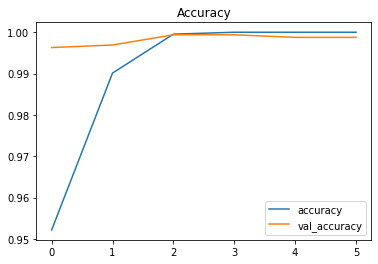

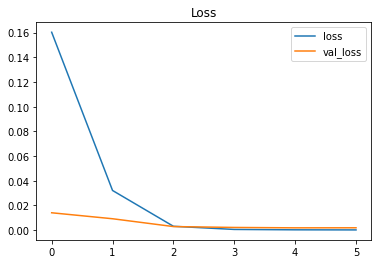

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
Loss, Accuracy = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(Loss))
print("Test Accuracy: {:.2f}%".format(Accuracy * 100))

    Test Loss: 0.00346
Test Accuracy: 99.89%


In [ ]:



pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)


Map = dict((v,k) for k,v in (train_images.class_indices).items())




pred = pd.Series(pred).map(Map).values

# Classification report

y_test = list(test_df.label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       105
   Gilt-Head Bream       1.00      1.00      1.00       112
   Hourse Mackerel       1.00      1.00      1.00        92
        Red Mullet       1.00      1.00      1.00        99
     Red Sea Bream       1.00      1.00      1.00       105
          Sea Bass       0.99      1.00      0.99        90
            Shrimp       1.00      1.00      1.00       106
Striped Red Mullet       1.00      1.00      1.00        91
             Trout       1.00      0.99      0.99       100

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



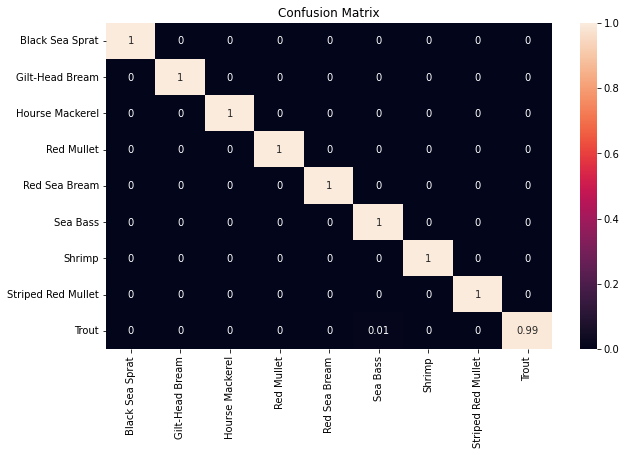

In [ ]:
import seaborn as sns

CM = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(CM, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix')
plt.show()


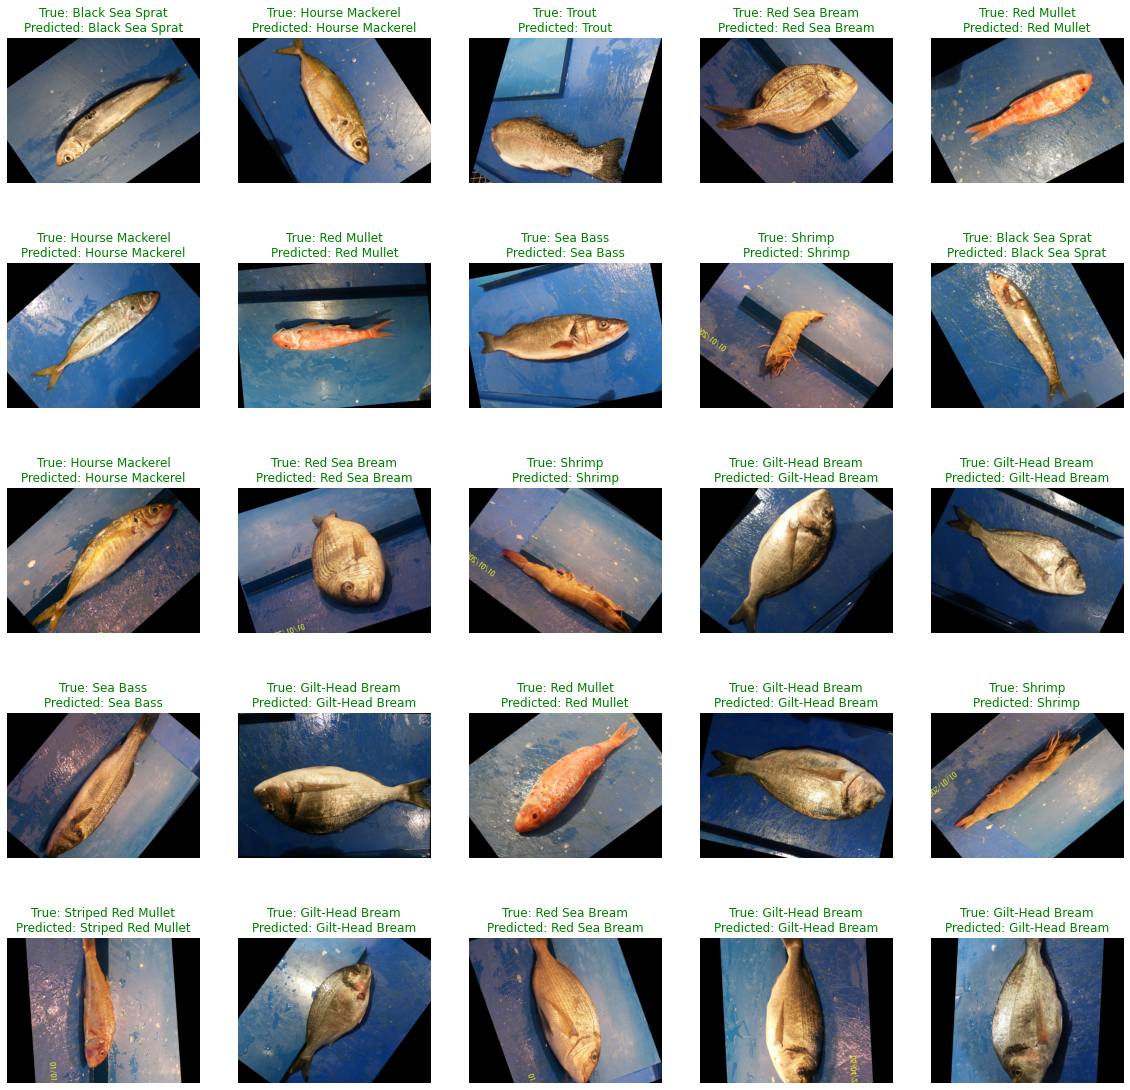

In [ ]:
plt.figure(figsize=(20, 20))
n_img = (5, 5)

for i in range(1, (n_img[0] * n_img[1])+1):
    plt.subplot(n_img[0], n_img[1], i)
    plt.axis('off')

    color='green'
    if test_df.label.iloc[i] != pred[i]:
        color='red'

    plt.title(f"True: {test_df.label.iloc[i]}\nPredicted: {pred[i]}", color=color)
    plt.imshow(plt.imread(test_df['img_dir'].iloc[i]))


In [ ]:
pred[0]

'Hourse Mackerel'

In [ ]:
test_df.label.iloc[0]

'Hourse Mackerel'